In [44]:
!pip install bertopic
!pip install bertopic[visualization]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
#import dependencies
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer, util
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
import numpy as np
import os

In [46]:
os.chdir('..')
# Read data into papers
papers = pd.read_csv('/content/drive/MyDrive/AI/Topic_Modelling/papers.csv')
# Print head
papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In [47]:
# Remove the columns
papers = papers.drop(columns=['id', 'event_type', 'pdf_name'], axis=1)
# Print out the first rows of papers
papers.head()

,year,title,abstract,paper_text
0,1987,Self-Organization of Associative Database and ...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,1987,A Mean Field Theory of Layer IV of Visual Cort...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,1988,Storing Covariance by the Associative Long-Ter...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1994,Bayesian Query Construction for Neural Network...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1994,"Neural Network Ensembles, Cross Validation, an...",Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


### Cleaning data - removing punctuation and lower case

In [48]:
# Load the regular expression library
import re
# Remove punctuation
papers['paper_text_processed'] = \
papers['paper_text'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
papers['paper_text_processed'] = \
papers['paper_text_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
papers['paper_text_processed'].head()

0    767\n\nself-organization of associative databa...
1    683\n\na mean field theory of layer iv of visu...
2    394\n\nstoring covariance by the associative\n...
3    bayesian query construction for neural\nnetwor...
4    neural network ensembles cross\nvalidation and...
Name: paper_text_processed, dtype: object

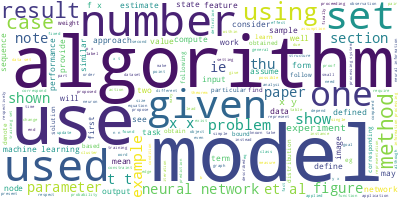

In [49]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(papers['paper_text_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [50]:
docs = papers.paper_text_processed.values

# Bertopic

### Extract embeddings

In [51]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

### Reduce Dimensionality

In [52]:
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

### Cluster Reduced Embedding

In [53]:
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

### Tokenise topics

In [54]:
vectorizer_model = CountVectorizer(stop_words="english")

### Creating topic representation

In [55]:
ctfidf_model = ClassTfidfTransformer()

### Creating topic model

In [56]:
topic_model = BERTopic(
  embedding_model=embedding_model,    # Step 1 - Extract embeddings
  umap_model=umap_model,              # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words
  #diversity=0.5,                      # Diversify topic words
  calculate_probabilities=True,        
  verbose=True
)

# Generating topics

In [57]:
topics, probs = topic_model.fit_transform(docs)
topic_model.get_topic_info()

Batches:   0%|          | 0/227 [00:00<?, ?it/s]

2023-03-14 16:03:47,447 - BERTopic - Transformed documents to Embeddings
2023-03-14 16:04:06,551 - BERTopic - Reduced dimensionality
2023-03-14 16:04:09,586 - BERTopic - Clustered reduced embeddings


,Topic,Count,Name
0,-1,2402,-1_data_model_learning_set
1,0,525,0_policy_state_action_reward
2,1,179,1_network_networks_hidden_units
3,2,164,2_clustering_clusters_cluster_means
4,3,156,3_gp_gaussian_covariance_process
...,...,...,...
88,87,15,87_kernel_feature_descriptors_descriptor
89,88,15,88_tree_trees_forests_split
90,89,15,89_feature_selection_features_cmh
91,90,15,90_neurons_spiking_synaptic_neuron


In [58]:
topic_model.visualize_topics()